# E-commerce Capstone

## Imports & Loading

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub

# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 50_000  # Steam sample size
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(df, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    n = len(df)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return df.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = df.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(df, y, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    y_arr = df[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(df)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return df.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(df, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = df.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # choose sampling method
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist (full):", None if olist is None else olist.shape)
print("sales (full):", None if sales is None else sales.shape)


/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 50000, 'frac': 0.0012149252891412844, 'elapsed_sec': 5.886, 'mode': 'stratified'}
steam: (50000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441, 

### Steam Game Reviews

##### EDA

In [2]:
steam

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,products,reviews
0,387290,0,0,2021-10-31,True,19.000000,13787757,29310874,Ori and the Blind Forest: Definitive Edition,2016-04-27,...,95,49633,19.990000,19.990000,0.000000,True,“Ori and the Blind Forest” tells the tale of a...,"[Atmospheric, Great Soundtrack, Metroidvania, ...",1898,125
1,292030,0,0,2020-06-17,True,279.500000,7653941,36248929,The Witcher® 3: Wild Hunt,2015-05-18,...,96,668455,40.000000,0.000000,0.000000,True,,[],93,4
2,1113560,0,0,2021-10-04,True,56.700000,1624761,7874416,NieR Replicant™ ver.1.22474487139...,2021-04-23,...,88,14951,59.990000,59.990000,0.000000,True,The upgraded prequel of NieR:Automata. A kind ...,"[Great Soundtrack, Story Rich, Action, RPG, Ad...",281,25
3,22610,0,0,2020-12-29,True,8.800000,11583823,36507746,Alien Breed: Impact,2010-06-03,...,77,815,9.990000,9.990000,0.000000,True,Experience the explosive science fiction arcad...,"[Action, Shooter, Sci-fi, Top-Down, Aliens, Co...",693,47
4,386180,0,0,2020-12-25,False,4.500000,14271799,26164919,Crossout,2017-07-26,...,75,56621,0.000000,0.000000,0.000000,True,,[],33,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1997040,0,0,2022-12-04,True,531.500000,10864431,22333350,MARVEL SNAP,2023-08-22,...,82,17659,0.000000,0.000000,0.000000,True,,[],21,1
49996,1222730,0,0,2020-10-14,True,18.800000,11339735,9346514,STAR WARS™: Squadrons,2020-10-01,...,70,21288,39.990000,39.990000,0.000000,True,Master the art of starfighter combat in the au...,"[Flight, Space, Multiplayer, VR, Sci-fi, Singl...",370,12
49997,222880,0,0,2019-12-20,True,58.400000,8331295,32045553,Insurgency,2014-01-22,...,91,86206,14.990000,14.990000,0.000000,True,Take to the streets for intense close quarters...,"[FPS, Realistic, Tactical, Multiplayer, Shoote...",110,7
49998,413150,2,0,2022-02-08,True,617.400000,2608300,5306565,Stardew Valley,2016-02-26,...,98,505882,15.000000,0.000000,0.000000,True,,[],14,2


In [3]:
steam.columns

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id', 'title', 'date_release', 'win', 'mac', 'linux',
       'rating', 'positive_ratio', 'user_reviews', 'price_final',
       'price_original', 'discount', 'steam_deck', 'description', 'tags',
       'products', 'reviews'],
      dtype='object')

In [4]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50000 non-null  int64  
 1   helpful         50000 non-null  int64  
 2   funny           50000 non-null  int64  
 3   date            50000 non-null  object 
 4   is_recommended  50000 non-null  bool   
 5   hours           50000 non-null  float64
 6   user_id         50000 non-null  int64  
 7   review_id       50000 non-null  int64  
 8   title           50000 non-null  object 
 9   date_release    50000 non-null  object 
 10  win             50000 non-null  bool   
 11  mac             50000 non-null  bool   
 12  linux           50000 non-null  bool   
 13  rating          50000 non-null  object 
 14  positive_ratio  50000 non-null  int64  
 15  user_reviews    50000 non-null  int64  
 16  price_final     50000 non-null  float64
 17  price_original  50000 non-null 

In [5]:
steam.describe(include="all")

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,products,reviews
count,50000.000000,50000.000000,50000.000000,50000,50000,50000.000000,50000.000000,50000.000000,50000,50000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000,50000,50000,50000.000000,50000.000000
unique,NaN,NaN,NaN,3622,2,NaN,NaN,NaN,6828,2821,...,NaN,NaN,NaN,NaN,NaN,2,6246,6254,NaN,NaN
top,NaN,NaN,NaN,2019-06-29,True,NaN,NaN,NaN,Team Fortress 2,2007-10-10,...,NaN,NaN,NaN,NaN,NaN,True,,[],NaN,NaN
freq,NaN,NaN,NaN,284,42892,NaN,NaN,NaN,399,604,...,NaN,NaN,NaN,NaN,NaN,49991,25191,25190,NaN,NaN
mean,604386.821920,3.388320,1.061980,NaN,NaN,99.615634,7438268.158040,20596746.315540,NaN,NaN,...,86.155860,174832.574400,18.592937,7.390880,3.172860,NaN,NaN,NaN,280.476700,25.409820
std,473608.047249,48.100170,22.062309,NaN,NaN,175.352559,4003348.467786,11892157.189810,NaN,NaN,...,11.191704,585639.057886,16.628919,12.026922,14.852819,NaN,NaN,NaN,667.973941,152.289019
min,10.000000,0.000000,0.000000,NaN,NaN,0.000000,208.000000,735.000000,NaN,NaN,...,5.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
25%,253822.500000,0.000000,0.000000,NaN,NaN,7.600000,4301076.750000,10282100.000000,NaN,NaN,...,82.000000,10022.000000,4.990000,0.000000,0.000000,NaN,NaN,NaN,50.000000,2.000000
50%,438100.000000,0.000000,0.000000,NaN,NaN,26.800000,7524689.500000,20630696.000000,NaN,NaN,...,89.000000,45437.000000,15.000000,0.000000,0.000000,NaN,NaN,NaN,118.000000,5.000000
75%,931692.500000,0.000000,0.000000,NaN,NaN,96.900000,10938626.500000,30939699.500000,NaN,NaN,...,94.000000,136118.000000,29.990000,14.990000,0.000000,NaN,NaN,NaN,271.000000,15.000000


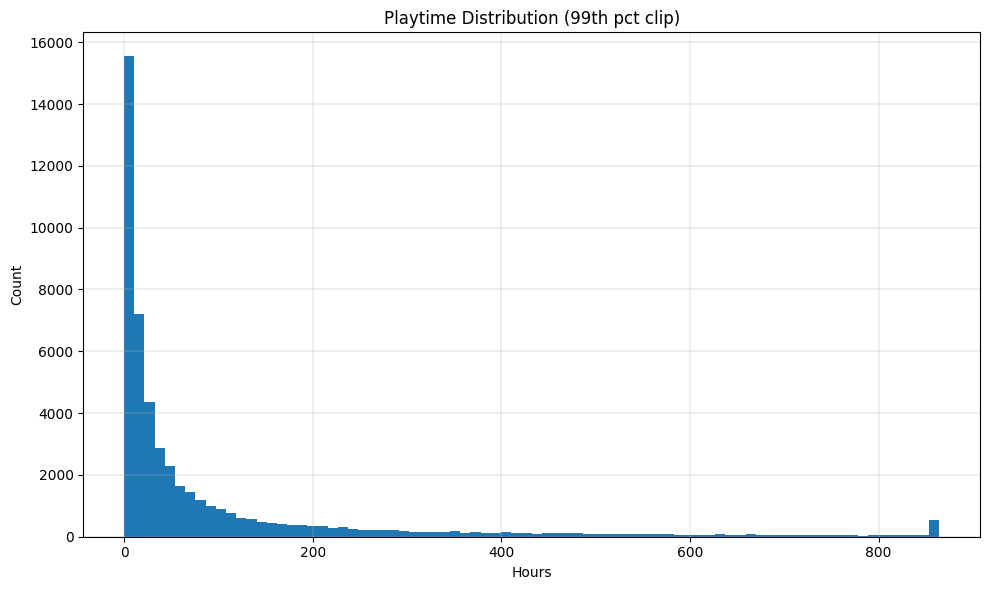

/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_18253/686624140.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([y, n], labels=["Recommended", "Not recommended"], showfliers=False)


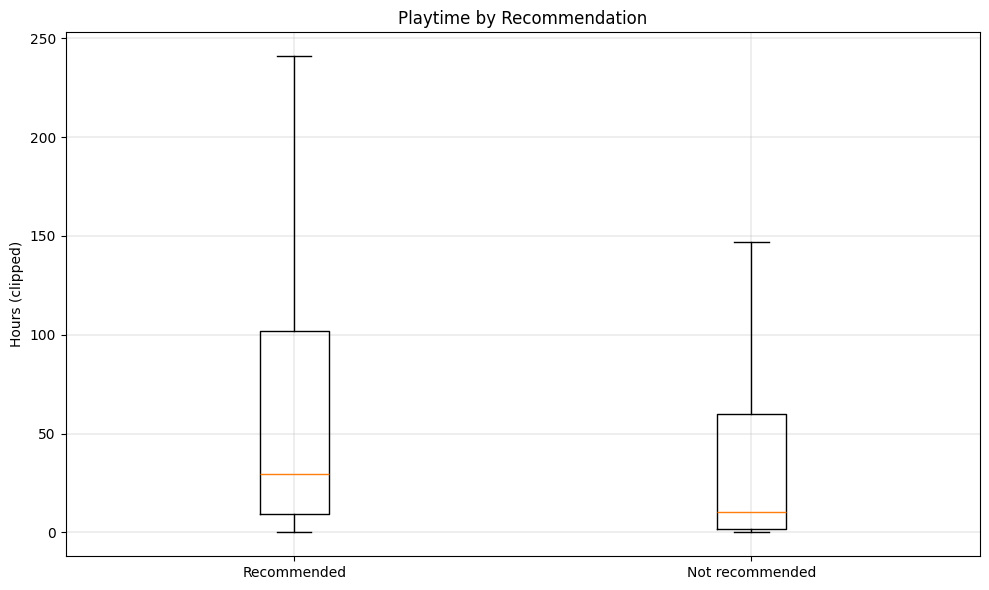

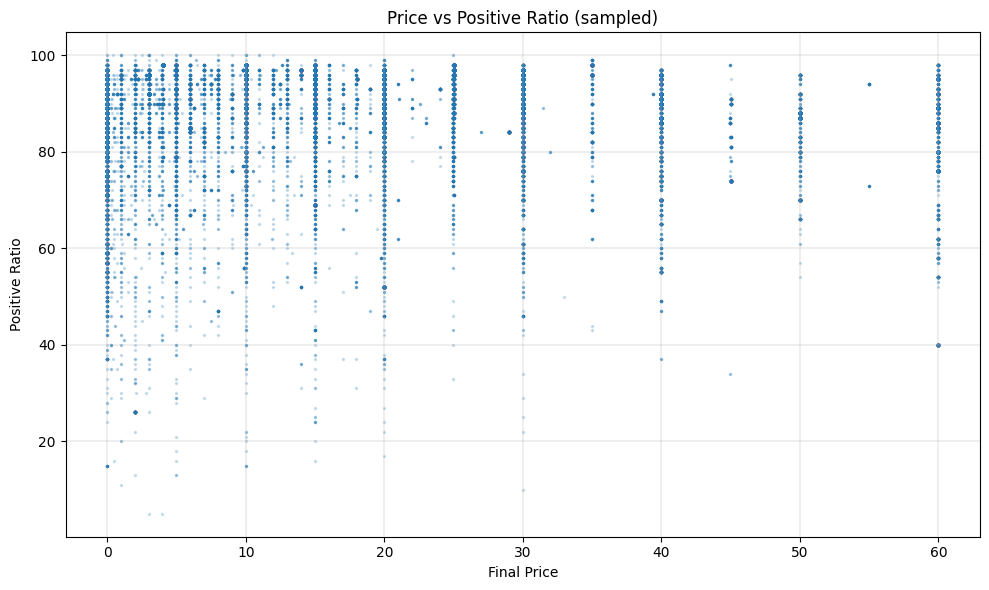

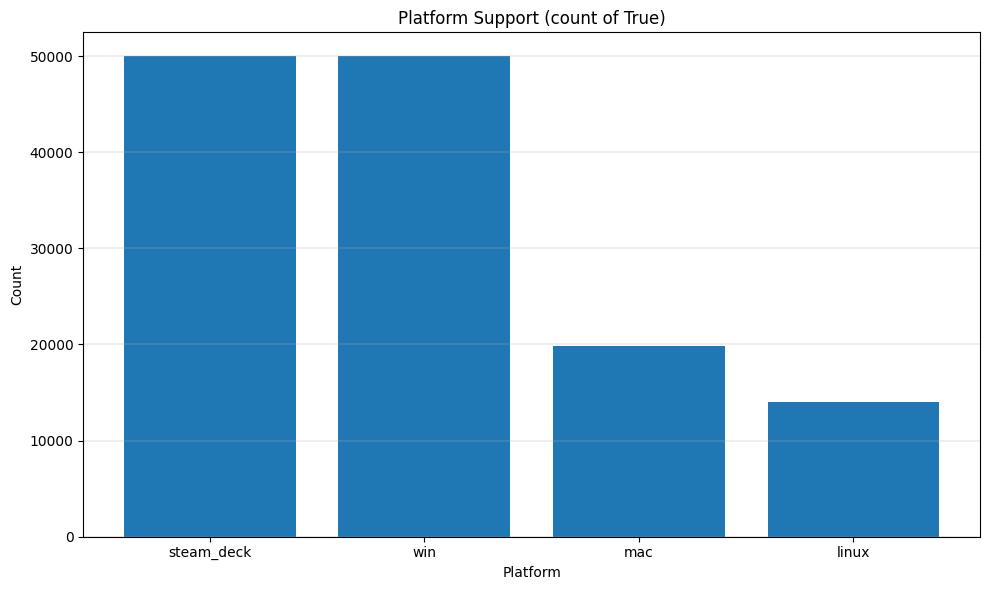

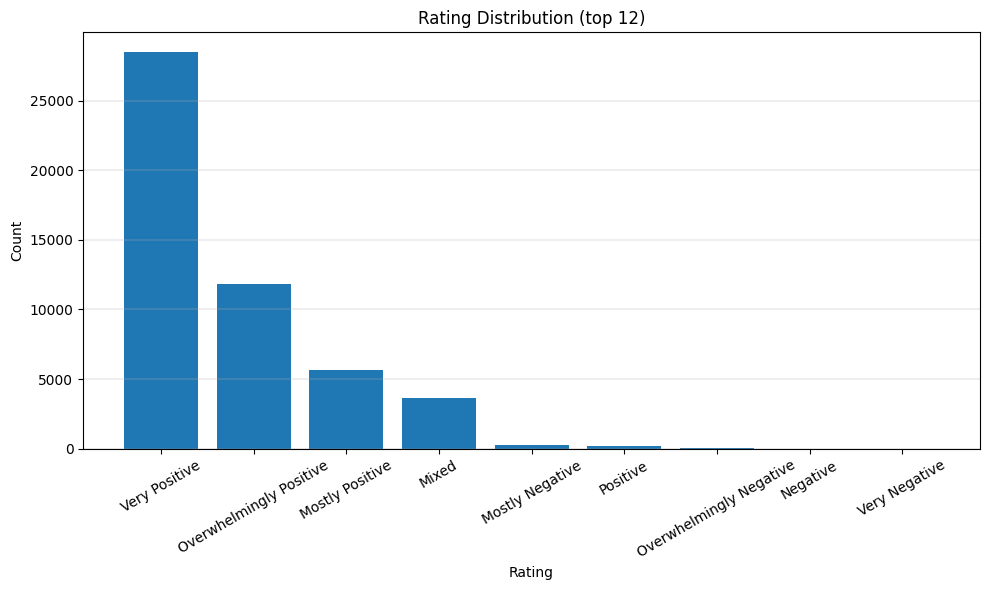

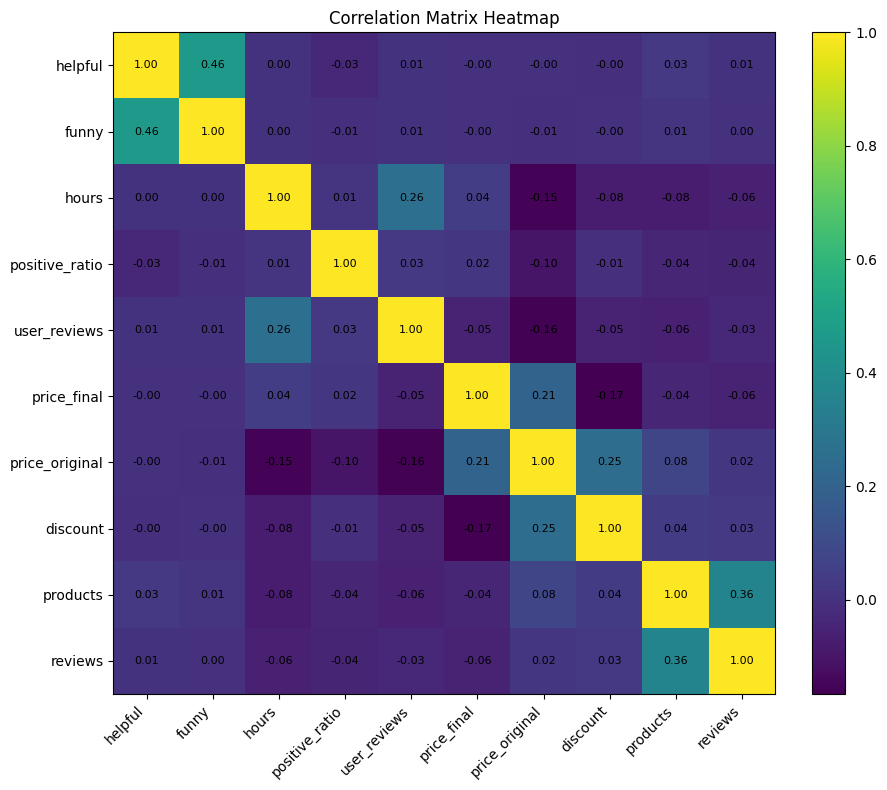

In [6]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

steam = steam.copy()

for c in ["date", "date_release"]:
    if c in steam.columns:
        steam[c] = pd.to_datetime(steam[c], errors="coerce")

if "hours" in steam.columns:
    h_cap = np.nanpercentile(steam["hours"].dropna(), 99)
    steam["hours_clipped"] = steam["hours"].clip(0, h_cap)

if "price_final" in steam.columns:
    p_cap = np.nanpercentile(steam["price_final"].dropna(), 99)
    steam["price_final_clipped"] = steam["price_final"].clip(0, p_cap)

def plain_ticks(ax, which=("x","y")):
    if "x" in which and isinstance(ax.xaxis.get_major_formatter(), mticker.ScalarFormatter):
        ax.xaxis.get_major_formatter().set_scientific(False)
        ax.xaxis.get_major_formatter().set_useOffset(False)
    if "y" in which and isinstance(ax.yaxis.get_major_formatter(), mticker.ScalarFormatter):
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.yaxis.get_major_formatter().set_useOffset(False)

# 1) Playtime histogram
if "hours_clipped" in steam.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(steam["hours_clipped"].dropna(), bins=80)
    ax.set_title("Playtime Distribution (99th pct clip)")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Count")
    ax.grid(True, linewidth=0.3)
    plain_ticks(ax, ("x","y"))
    fig.tight_layout()
    plt.show()

# 2) Playtime by recommendation (box)
if {"hours_clipped", "is_recommended"}.issubset(steam.columns):
    y = steam.loc[steam["is_recommended"] == True, "hours_clipped"].dropna().values
    n = steam.loc[steam["is_recommended"] == False, "hours_clipped"].dropna().values
    if len(y) > 0 and len(n) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.boxplot([y, n], labels=["Recommended", "Not recommended"], showfliers=False)
        ax.set_title("Playtime by Recommendation")
        ax.set_ylabel("Hours (clipped)")
        ax.grid(True, linewidth=0.3)
        plain_ticks(ax, ("y",))
        fig.tight_layout()
        plt.show()

# 3) Price vs positive ratio (scatter, sampled)
if {"price_final_clipped", "positive_ratio"}.issubset(steam.columns):
    s = steam[["price_final_clipped", "positive_ratio"]].dropna()
    s = s.sample(n=min(200_000, len(s)), random_state=42)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(s["price_final_clipped"], s["positive_ratio"], s=2, alpha=0.2)
    ax.set_title("Price vs Positive Ratio (sampled)")
    ax.set_xlabel("Final Price")
    ax.set_ylabel("Positive Ratio")
    ax.grid(True, linewidth=0.3)
    plain_ticks(ax, ("x","y"))
    fig.tight_layout()
    plt.show()

# 4) Platform support (bar)
pl_cols = [c for c in ["win", "mac", "linux", "steam_deck"] if c in steam.columns]
if pl_cols:
    counts = steam[pl_cols].sum().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("Platform Support (count of True)")
    ax.set_xlabel("Platform")
    ax.set_ylabel("Count")
    ax.grid(True, axis="y", linewidth=0.3)
    plain_ticks(ax, ("y",))
    fig.tight_layout()
    plt.show()

# 5) Rating distribution (bar)
if "rating" in steam.columns:
    top_r = steam["rating"].fillna("Unknown").value_counts().head(12)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(top_r.index.astype(str), top_r.values)
    ax.set_title("Rating Distribution (top 12)")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, axis="y", linewidth=0.3)
    plain_ticks(ax, ("y",))
    fig.tight_layout()
    plt.show()

# 6) Correlation heatmap
num_cols = [c for c in [
    "helpful","funny","hours","positive_ratio","user_reviews",
    "price_final","price_original","discount","products","reviews"
] if c in steam.columns]
if len(num_cols) >= 2:
    corr = steam[num_cols].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr, interpolation="nearest")
    ax.set_title("Correlation Matrix Heatmap")
    fig.colorbar(im, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(num_cols)), labels=num_cols, rotation=45, ha="right")
    ax.set_yticks(range(len(num_cols)), labels=num_cols)
    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha="center", va="center", fontsize=8)
    fig.tight_layout()
    plt.show()


##### Cleaning

In [7]:
def clean_steam(df, clip_q=0.999):
    import pandas as pd
    import numpy as np

    df = df.copy()

    # dates
    for c in ["date", "date_release"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True).dt.tz_localize(None)

    # text
    for c in ["title", "description"]:
        if c in df.columns:
            s = df[c].astype("string")
            df[c] = s.str.strip().replace("", pd.NA)

    # rating -> ordered category
    if "rating" in df.columns:
        r = df["rating"].astype("string").str.strip().str.lower().str.replace(r"\s+", " ", regex=True)
        cats = [
            "overwhelmingly negative","very negative","negative","mostly negative",
            "mixed","mostly positive","positive","very positive","overwhelmingly positive"
        ]
        df["rating"] = pd.Categorical(r.where(r.isin(cats)), categories=cats, ordered=True)

    # bounds and caps
    if "positive_ratio" in df.columns:
        df["positive_ratio"] = pd.to_numeric(df["positive_ratio"], errors="coerce").clip(0, 100)

    if "hours" in df.columns:
        df["hours"] = pd.to_numeric(df["hours"], errors="coerce")
        df.loc[df["hours"] < 0, "hours"] = np.nan
        cap = df["hours"].quantile(clip_q)
        if np.isfinite(cap):
            df["hours"] = df["hours"].clip(upper=float(cap))

    # prices and discount
    if {"price_final", "price_original"}.issubset(df.columns):
        pf = pd.to_numeric(df["price_final"], errors="coerce").where(lambda x: x >= 0)
        po = pd.to_numeric(df["price_original"], errors="coerce").where(lambda x: x >= 0)
        po = np.where((pd.notna(po)) & (pd.notna(pf)) & (po < pf), pf, po)
        df["price_final"] = pf
        df["price_original"] = po

    if {"price_final", "price_original", "discount"}.issubset(df.columns):
        pf, po = df["price_final"], df["price_original"]
        disc = pd.to_numeric(df["discount"], errors="coerce")
        calc = (1 - (pf / po)).where(po > 0)
        df["discount"] = disc.where((disc >= 0) & (disc <= 1), calc).clip(0, 1)

    # booleans and platform summary
    for c in ["win", "mac", "linux", "steam_deck"]:
        if c in df.columns:
            df[c] = df[c].astype("boolean")
    if {"win", "mac", "linux"}.issubset(df.columns):
        df["platform_count"] = df[["win", "mac", "linux"]].sum(axis=1, min_count=1)

    # tags normalized (string, lightweight)
    if "tags" in df.columns:
        t = df["tags"].astype("string").str.strip().str.lower()
        t = t.str.replace(r"[\[\]{}'\"\s]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
        df["tags"] = t.mask(t == "")

    # dedupe by review_id, prefer newest
    if "review_id" in df.columns:
        df = df.sort_values("date", kind="stable").drop_duplicates("review_id", keep="last")

    # required keys present
    keys = [c for c in ["app_id", "user_id", "review_id"] if c in df.columns]
    if keys:
        df = df.dropna(subset=keys)

    return df

# usage
steam = clean_steam(steam)


In [8]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 4909 to 49847
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   app_id               50000 non-null  int64         
 1   helpful              50000 non-null  int64         
 2   funny                50000 non-null  int64         
 3   date                 50000 non-null  datetime64[ns]
 4   is_recommended       50000 non-null  bool          
 5   hours                50000 non-null  float64       
 6   user_id              50000 non-null  int64         
 7   review_id            50000 non-null  int64         
 8   title                50000 non-null  string        
 9   date_release         50000 non-null  datetime64[ns]
 10  win                  50000 non-null  boolean       
 11  mac                  50000 non-null  boolean       
 12  linux                50000 non-null  boolean       
 13  rating               50000 non-nu

##### Encoding

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def encode_steam(steam: pd.DataFrame,
                 tag_max_features: int = 256,
                 tag_sample: int = 1_000_000) -> pd.DataFrame:
    # numerics except booleans
    numeric_cols = [
        c for c in steam.columns
        if pd.api.types.is_numeric_dtype(steam[c])
        and not pd.api.types.is_bool_dtype(steam[c])
    ]
    parts = [steam[numeric_cols]]

    # booleans -> UInt8
    bool_cols = [c for c in steam.columns if pd.api.types.is_bool_dtype(steam[c])]
    if bool_cols:
        parts.append(steam[bool_cols].astype("UInt8"))

    # rating -> one-hot UInt8
    if "rating" in steam.columns:
        rat = steam["rating"].astype("string").fillna("NA")
        rat_dum = pd.get_dummies(rat, prefix="rating", dtype="UInt8")
        parts.append(rat_dum)

    # tags -> top-N multi-hot (sparse)
    if "tags" in steam.columns:
        tags_series = steam["tags"].fillna("")
        fit_series = (
            tags_series.sample(tag_sample, random_state=0)
            if len(tags_series) > tag_sample else tags_series
        )
        vec = CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            binary=True,
            max_features=tag_max_features,
            dtype=np.uint8,
        )
        vec.fit(fit_series.tolist())
        X_tags = vec.transform(tags_series.tolist())
        tag_cols = [f"tag_{t}" for t in vec.get_feature_names_out()]
        tags_df = pd.DataFrame.sparse.from_spmatrix(X_tags, index=steam.index, columns=tag_cols)
        parts.append(tags_df)

    # drop obvious text fields if present
    drop_text = [c for c in ("title", "description", "tags") if c in steam.columns]

    X = pd.concat(parts, axis=1)
    X = X.loc[:, ~X.columns.isin(drop_text)]

    return X

# usage
steam = encode_steam(steam, tag_max_features=256)
steam.info()


/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 4909 to 49847
Columns: 286 entries, app_id to tag_zombies
dtypes: Int64(1), Sparse[uint8, 0](256), UInt8(14), float64(6), int64(9)
memory usage: 10.0 MB


In [10]:
list(steam.columns)

['app_id',
 'helpful',
 'funny',
 'hours',
 'user_id',
 'review_id',
 'positive_ratio',
 'user_reviews',
 'price_final',
 'price_original',
 'discount',
 'products',
 'reviews',
 'hours_clipped',
 'price_final_clipped',
 'platform_count',
 'is_recommended',
 'win',
 'mac',
 'linux',
 'steam_deck',
 'rating_mixed',
 'rating_mostly negative',
 'rating_mostly positive',
 'rating_negative',
 'rating_overwhelmingly negative',
 'rating_overwhelmingly positive',
 'rating_positive',
 'rating_very negative',
 'rating_very positive',
 'tag_1980s',
 'tag_1990 s',
 'tag_2.5d',
 'tag_2d',
 'tag_2d fighter',
 'tag_2d platformer',
 'tag_3d',
 'tag_3d platformer',
 'tag_3d vision',
 'tag_4 player local',
 'tag_action',
 'tag_action roguelike',
 'tag_action rpg',
 'tag_action-adventure',
 'tag_addictive',
 'tag_adventure',
 'tag_aliens',
 'tag_alternate history',
 'tag_anime',
 'tag_arcade',
 'tag_arena shooter',
 'tag_assassin',
 'tag_atmospheric',
 'tag_automobile sim',
 'tag_base building',
 'tag_ba

##### Engineering

In [11]:
def engineer_steam_features(df_in):
    """
    Adds robust, model-ready features and returns (X, y).
    Uses clipped fields when available. Safe against missing cols.
    """
    df = df_in.copy()

    # ---- helpers ----
    def has(c): return c in df.columns
    def cols_start(prefix): return [c for c in df.columns if c.startswith(prefix)]
    def safe_div(num, den):
        den = np.where(den > 0, den, 1.0)
        return num / den

    # ---- basic fills ----
    fill_zeros = [c for c in [
        "helpful","funny","hours","hours_clipped","user_reviews","reviews",
        "positive_ratio","price_final","price_original","price_final_clipped",
        "discount","products"
    ] if has(c)]
    for c in fill_zeros:
        df[c] = df[c].fillna(0)

    # ---- cast binaries to uint8 ----
    bool_like = [c for c in ["is_recommended","win","mac","linux","steam_deck"] if has(c)]
    for c in bool_like:
        df[c] = df[c].astype("uint8")

    tag_cols = cols_start("tag_")
    rating_cols = [c for c in [
        "rating_mixed","rating_mostly negative","rating_mostly positive",
        "rating_negative","rating_overwhelmingly negative",
        "rating_overwhelmingly positive","rating_positive",
        "rating_very negative","rating_very positive"
    ] if has(c)]
    for c in tag_cols + rating_cols:
        df[c] = df[c].fillna(0).astype("uint8")

    # ---- platform features ----
    pcols = [c for c in ["win","mac","linux"] if has(c)]
    if pcols:
        df["platform_count"] = df[pcols].sum(axis=1).astype("uint8")
        if set(pcols) == {"win","mac","linux"}:
            df["platform_all"] = (df["win"] & df["mac"] & df["linux"]).astype("uint8")
            df["platform_windows_only"] = ((df["win"]==1) & (df["mac"]==0) & (df["linux"]==0)).astype("uint8")
            df["platform_mac_only"] = ((df["win"]==0) & (df["mac"]==1) & (df["linux"]==0)).astype("uint8")
            df["platform_linux_only"] = ((df["win"]==0) & (df["mac"]==0) & (df["linux"]==1)).astype("uint8")

    # ---- price/discount/value ----
    if has("price_original") and has("price_final"):
        df["calc_discount_abs"] = (df["price_original"] - df["price_final"]).clip(lower=0).astype("float32")
        df["calc_discount_pct"] = np.where(df["price_original"] > 0,
                                           df["calc_discount_abs"] / df["price_original"], 0.0).astype("float32")
        df["is_free"] = (df["price_final"] <= 0).astype("uint8")
    if has("hours_clipped") and has("price_final_clipped"):
        df["price_per_hour"] = safe_div(df["price_final_clipped"], df["hours_clipped"]).astype("float32")

    # ---- engagement ratios ----
    if has("reviews"):
        den_rev = np.where(df["reviews"] > 0, df["reviews"], 1.0)
        if has("helpful"): df["helpful_rate"] = (df["helpful"] / den_rev).astype("float32")
        if has("funny"):   df["funny_rate"]   = (df["funny"]   / den_rev).astype("float32")
        if has("helpful") and has("funny"):
            df["interaction_rate"] = ((df["helpful"] + df["funny"]) / den_rev).astype("float32")
    if has("hours_clipped") and has("helpful") and has("funny"):
        df["interactions_per_hour"] = safe_div(df["helpful"] + df["funny"], df["hours_clipped"]).astype("float32")

    # ---- log1p stabilizers ----
    for c in ["helpful","funny","reviews","user_reviews","price_final_clipped","price_original","hours_clipped","products"]:
        if has(c):
            df[f"{c}_log1p"] = np.log1p(df[c]).astype("float32")

    # ---- normalized sentiment ----
    if has("positive_ratio"):
        df["pos_ratio_norm"] = (df["positive_ratio"] / 100.0).astype("float32")

    # ---- rating score (one-hot -> scalar) ----
    rating_weights = {
        "rating_overwhelmingly positive":  2.0,
        "rating_very positive":            1.5,
        "rating_positive":                 1.0,
        "rating_mostly positive":          0.5,
        "rating_mixed":                    0.0,
        "rating_mostly negative":         -0.5,
        "rating_negative":                -1.0,
        "rating_very negative":           -1.5,
        "rating_overwhelmingly negative": -2.0,
    }
    if rating_cols:
        rs = np.zeros(len(df), dtype="float32")
        for col, w in rating_weights.items():
            if has(col):
                rs = rs + df[col].values.astype("float32") * w
        df["rating_score"] = rs.astype("float32")

    # ---- tag aggregates ----
    if tag_cols:
        df["tag_count"] = df[tag_cols].sum(axis=1).astype("uint16")
        adult = [c for c in ["tag_nsfw","tag_nudity","tag_sexual content","tag_mature","tag_hentai"] if has(c)]
        if adult: df["adult_content_tags"] = df[adult].sum(axis=1).clip(upper=5).astype("uint8")
        viol = [c for c in ["tag_gore","tag_violent","tag_blood","tag_horror","tag_survival horror","tag_psychological horror"] if has(c)]
        if viol: df["violence_tags"] = df[viol].sum(axis=1).clip(upper=6).astype("uint8")
        coop = [c for c in ["tag_co-op","tag_local co-op","tag_online co-op","tag_team-based","tag_pve","tag_pvp","tag_multiplayer","tag_split screen","tag_local multiplayer"] if has(c)]
        if coop: df["coop_pvp"] = df[coop].sum(axis=1).clip(upper=9).astype("uint8")
        hardcore = [c for c in ["tag_roguelike","tag_roguelite","tag_souls-like","tag_metroidvania","tag_difficult"] if has(c)]
        if hardcore: df["hardcore_tags"] = df[hardcore].sum(axis=1).clip(upper=5).astype("uint8")
        genres = [c for c in ["tag_action","tag_adventure","tag_strategy","tag_rpg","tag_simulation","tag_sports","tag_indie"] if has(c)]
        if genres: df["genre_tags"] = df[genres].sum(axis=1).clip(upper=7).astype("uint8")

    # ---- build X, y ----
    y = df["is_recommended"].astype("uint8") if has("is_recommended") else None

    base_feats = [c for c in [
        "hours_clipped","price_final_clipped","price_per_hour",
        "price_original","calc_discount_abs","calc_discount_pct","is_free",
        "platform_count","platform_all","platform_windows_only","platform_mac_only","platform_linux_only",
        "pos_ratio_norm","rating_score",
        "helpful_rate","funny_rate","interaction_rate","interactions_per_hour",
        "helpful_log1p","funny_log1p","reviews_log1p","user_reviews_log1p","hours_log1p","price_final_clipped_log1p","price_original_log1p","products_log1p",
        "adult_content_tags","violence_tags","coop_pvp","hardcore_tags","genre_tags",
        "steam_deck","win","mac","linux",
        "positive_ratio","user_reviews","products","reviews","discount","price_final"
    ] if has(c)]

    X = df[base_feats + tag_cols + rating_cols].copy()

    # dtype tighten for floats
    float_cols = X.select_dtypes(include=["float64"]).columns
    if len(float_cols):
        X[float_cols] = X[float_cols].astype("float32")

    return X, y

X, y = engineer_steam_features(steam)
X.shape, None if y is None else y.shape

/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_18253/3442238188.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["platform_all"] = (df["win"] & df["mac"] & df["linux"]).astype("uint8")
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_18253/3442238188.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["platform_windows_only"] = ((df["win"]==1) & (df["mac"]==0) & (df["linux"]==0)).astype("uint8")
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_18253/3442238188.py:46: PerformanceWarning:

((50000, 305), (50000,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

##### Selection

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import clone
from sklearn.pipeline import Pipeline

def _get_estimator(m):
    # get final estimator if pipeline
    return m.steps[-1][1] if isinstance(m, Pipeline) else m

def _model_importances(mdl):
    # try feature_importances_, else |coef_|
    est = _get_estimator(mdl)
    fi = getattr(est, "feature_importances_", None)
    if fi is not None:
        return np.asarray(fi)
    coef = getattr(est, "coef_", None)
    if coef is None:
        return None
    coef = np.asarray(coef)
    return np.mean(np.abs(coef), axis=0) if coef.ndim > 1 else np.abs(coef)

def forward_feature_selection(
    X, y, model,
    scoring="f1_macro",
    cv=3,
    tol=None,
    max_features=50,
    n_jobs=-1,
    verbose=True,
    prefilter_k=150,
    random_state=0,
    feature_names=None,
    plot_importances=True,
    top_n_importances=30,
):
    # names
    if feature_names is not None:
        names = list(feature_names)
    elif hasattr(X, "columns"):
        names = list(X.columns)
    elif hasattr(X, "get_feature_names_out"):
        names = list(X.get_feature_names_out())
    elif hasattr(model, "feature_names_in_"):
        names = list(model.feature_names_in_)
    else:
        names = None

    # array
    X_arr = X.values if hasattr(X, "values") else np.asarray(X)
    if names is None:
        names = [f"f{i}" for i in range(X_arr.shape[1])]
    if len(names) != X_arr.shape[1]:
        raise ValueError("feature_names length does not match X columns")

    # prefilter with a fast tree
    y_arr = np.asarray(y)
    is_classifier = np.unique(y_arr).size <= 20
    tree = DecisionTreeClassifier(random_state=random_state) if is_classifier else DecisionTreeRegressor(random_state=random_state)
    tree.fit(X_arr, y_arr)
    importances = getattr(tree, "feature_importances_", None)

    if importances is None or float(np.nansum(importances)) == 0.0:
        keep_idx = list(range(min(prefilter_k, X_arr.shape[1])))
        kept_importances = None
    else:
        top_idx = np.argsort(importances)[::-1][:min(prefilter_k, X_arr.shape[1])]
        keep_idx = list(np.sort(top_idx))
        kept_importances = importances[keep_idx]

    X_arr = X_arr[:, keep_idx]
    names = [names[i] for i in keep_idx]

    # plot prefilter importances
    if plot_importances and kept_importances is not None:
        order = np.argsort(kept_importances)[::-1][:min(top_n_importances, len(names))]
        plt.figure(figsize=(8, 0.28 * len(order) + 1))
        plt.barh([names[i] for i in order][::-1], kept_importances[order][::-1])
        plt.xlabel("Tree importance")
        plt.title("Prefilter Feature Importances")
        plt.tight_layout()
        plt.show()

    neg_loss = isinstance(scoring, str) and scoring.startswith("neg_")
    selected_idx = []
    remaining_idx = list(range(X_arr.shape[1]))
    plot_scores = []
    best_perf = -np.inf
    best_set_idx = []

    if verbose:
        print(f"Prefilter kept {len(names)} features.")

    while remaining_idx:
        perfs = {}
        for idx in remaining_idx:
            cols = selected_idx + [idx]
            val = cross_val_score(model, X_arr[:, cols], y_arr, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            perfs[idx] = val

        best_idx = max(perfs, key=perfs.get)
        current = perfs[best_idx]
        improve = current - best_perf

        if tol is not None and improve < tol:
            if verbose:
                print("Stopping early (improvement < tol).")
            break

        selected_idx.append(best_idx)
        remaining_idx.remove(best_idx)
        best_set_idx = selected_idx.copy()
        best_perf = current
        plot_scores.append((-current) if neg_loss else current)

        if verbose:
            shown = (-current) if neg_loss else current
            print(f"Added {names[best_idx]} -> CV = {shown:.6f}")

        if max_features is not None and len(selected_idx) >= max_features:
            break

    selected_features = [names[i] for i in selected_idx]
    best_feature_set = [names[i] for i in best_set_idx]

    # learning curve
    if plot_scores:
        k_best = len(best_feature_set)
        plt.figure(figsize=(9, 5))
        plt.plot(range(1, len(plot_scores) + 1), plot_scores, marker=".")
        plt.plot([k_best], [plot_scores[k_best - 1]], marker="x")
        ylabel = (scoring[4:] + " (lower better)") if neg_loss else scoring
        plt.xlabel("k features")
        plt.ylabel(ylabel)
        plt.title("Forward Feature Selection (CV)")
        plt.grid(True, linewidth=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No features selected.")
        return [], [], [], None

    # final-model importances on best set
    if plot_importances and len(best_set_idx) > 0:
        mdl = clone(model)
        mdl.fit(X_arr[:, best_set_idx], y_arr)
        fi = _model_importances(mdl)
        if fi is not None:
            order = np.argsort(fi)[::-1]
            names_best = [best_feature_set[i] for i in order][:min(top_n_importances, len(order))]
            vals_best = fi[order][:len(names_best)]
            plt.figure(figsize=(8, 0.28 * len(names_best) + 1))
            plt.barh(list(reversed(names_best)), list(reversed(vals_best)))
            plt.xlabel("Model importance")
            plt.title("Final Model Feature Importances")
            plt.tight_layout()
            plt.show()

    best_shown = (-best_perf) if neg_loss else best_perf
    label = scoring[4:] if neg_loss else scoring
    print(f"Best Features: {best_feature_set}")
    print(f"Best CV {label}: {best_shown:.6f}")

    return selected_features, plot_scores, best_feature_set, best_shown

# example:
# selected, scores, best_set, best_score = forward_feature_selection(
#     X, y, model, scoring="f1_macro", cv=5, feature_names=list(df.columns)
# )


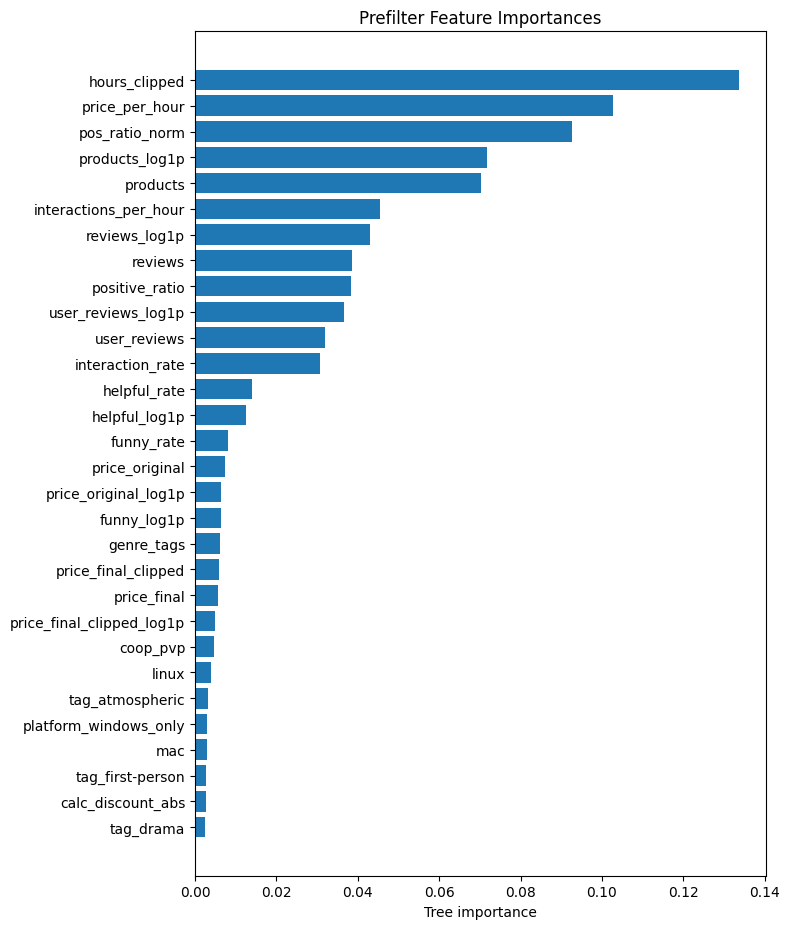

Prefilter kept 150 features.
Added interactions_per_hour -> CV = 0.555330
Added positive_ratio -> CV = 0.585917
Added reviews_log1p -> CV = 0.601034
Added helpful_rate -> CV = 0.607168
Added tag_sports -> CV = 0.608355
Added interaction_rate -> CV = 0.609184
Added tag_family friendly -> CV = 0.609639
Added tag_controller -> CV = 0.609565
Added tag_base building -> CV = 0.608989
Added tag_party-based rpg -> CV = 0.609867
Added tag_indie -> CV = 0.610142
Added tag_funny -> CV = 0.610557
Added tag_free to play -> CV = 0.612048
Added tag_world war ii -> CV = 0.614607
Added rating_score -> CV = 0.612825
Added calc_discount_abs -> CV = 0.613569
Added tag_roguelike -> CV = 0.613961
Added tag_local multiplayer -> CV = 0.613716
Added tag_clicker -> CV = 0.613276
Added tag_hack and slash -> CV = 0.612476
Added tag_character customization -> CV = 0.612676
Added tag_open world survival craft -> CV = 0.612621
Added tag_jrpg -> CV = 0.612668
Added tag_mature -> CV = 0.612909
Added tag_dating sim -> 

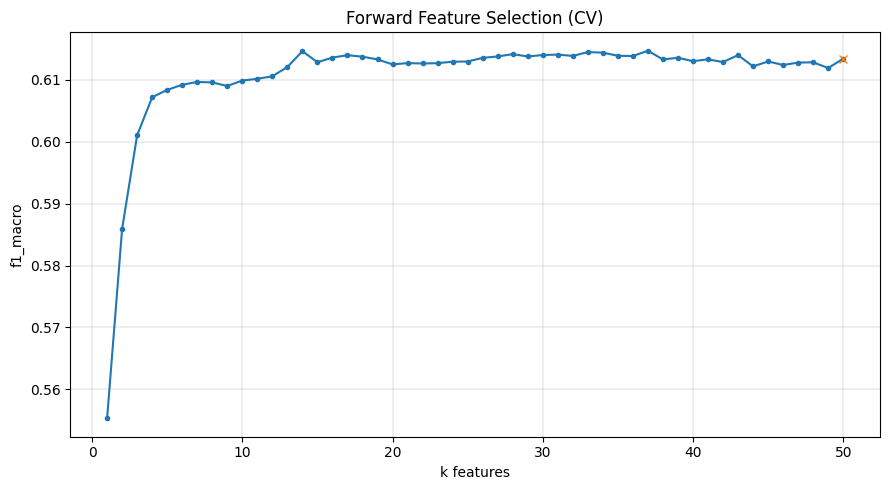

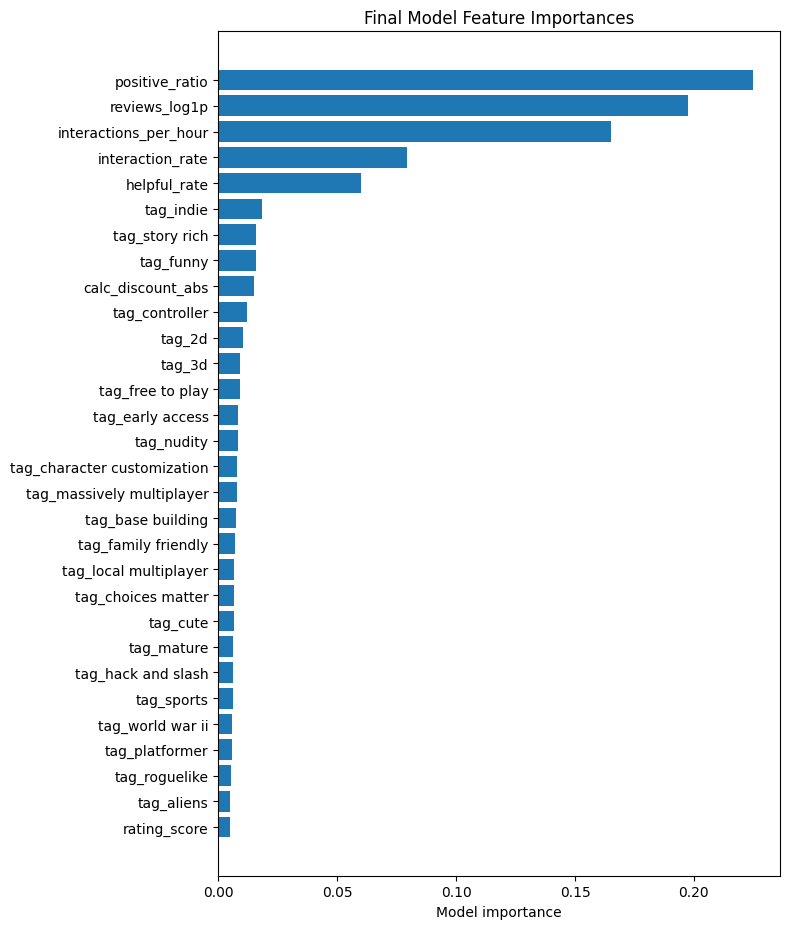

Best Features: ['interactions_per_hour', 'positive_ratio', 'reviews_log1p', 'helpful_rate', 'tag_sports', 'interaction_rate', 'tag_family friendly', 'tag_controller', 'tag_base building', 'tag_party-based rpg', 'tag_indie', 'tag_funny', 'tag_free to play', 'tag_world war ii', 'rating_score', 'calc_discount_abs', 'tag_roguelike', 'tag_local multiplayer', 'tag_clicker', 'tag_hack and slash', 'tag_character customization', 'tag_open world survival craft', 'tag_jrpg', 'tag_mature', 'tag_dating sim', 'tag_puzzle platformer', 'tag_cute', 'tag_esports', 'tag_assassin', 'tag_automobile sim', 'tag_thriller', 'tag_choices matter', 'tag_building', 'tag_point & click', 'tag_bullet hell', 'tag_flight', 'tag_crime', 'tag_story rich', 'tag_massively multiplayer', 'tag_dark comedy', 'tag_combat', 'tag_nudity', 'tag_3d', 'tag_2d', 'tag_aliens', 'tag_platformer', 'rating_mostly positive', 'tag_early access', 'rating_very positive', 'tag_board game']
Best CV f1_macro: 0.613390


In [25]:
model = DecisionTreeClassifier(random_state=42)
forward_selected_features, forward_best_scores, forward_best_subset, forward_best_score = forward_feature_selection(
    X_train_scaled, 
    y_train, 
    model, 
    verbose=True,
    feature_names=X_train.columns.tolist()
)

##### Modeling

In [27]:
from sklearn.ensemble import RandomForestClassifier

X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

forest_model = RandomForestClassifier(random_state=42)
forest_cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)

forest_scores = cross_val_score(
    forest_model,
    X_scaled_df[forward_best_subset],
    y_train,
    scoring="f1_macro",
    cv=forest_cv,
    n_jobs=-1
)

print("CV F1_macro:", f"{forest_scores.mean():.6f}")
print("STD CV F1_macro:", f"{forest_scores.std():.6f}")


CV F1_macro: 0.602698
STD CV F1_macro: 0.007393


### Olist Transactions

##### EDA

In [15]:
olist

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_value_total,payment_installments_max,payment_count,review_score_mean,review_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,13.000000,housewares,9350.000000,maua,SP,38.710000,1.000000,3.000000,4.000000,1.000000
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,19.000000,perfumery,31570.000000,belo horizonte,SP,141.460000,1.000000,1.000000,4.000000,1.000000
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,21.000000,auto,14840.000000,guariba,SP,179.120000,3.000000,1.000000,5.000000,1.000000
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,20.000000,pet_shop,31842.000000,belo horizonte,MG,72.200000,1.000000,1.000000,5.000000,1.000000
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,15.000000,stationery,8752.000000,mogi das cruzes,SP,28.620000,1.000000,1.000000,5.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,...,40.000000,baby,17602.000000,tupa,SP,195.000000,3.000000,1.000000,4.000000,1.000000
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,...,22.000000,home_appliances_2,8290.000000,sao paulo,SP,271.010000,5.000000,1.000000,5.000000,1.000000
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,20.000000,computers_accessories,37175.000000,ilicinea,MG,441.160000,4.000000,1.000000,2.000000,1.000000
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,20.000000,computers_accessories,37175.000000,ilicinea,MG,441.160000,4.000000,1.000000,2.000000,1.000000


##### Cleaning

##### Encoding

##### Engineering

##### Modeling

### Global Game Sales

In [16]:
sales

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.700000,...,NaN,NaN,NaN,NaN,2006.000000,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.000000,...,NaN,NaN,NaN,NaN,1985.000000,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.200000,...,NaN,NaN,NaN,NaN,2008.000000,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.700000,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.000000,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.000000,...,NaN,NaN,NaN,NaN,2009.000000,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.800000,/games/boxart/full_7295041AmericaFrontccc.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55787,55788,Indivisible,indivisible,Role-Playing,NaN,PC,505 Games,Lab Zero Games,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224682/indivisibl...,1,NaN,/games/boxart/full_6339426AmericaFrontccc.jpg
55788,55789,Lost Ember,lost-amber,Adventure,RP,PC,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/games/game.php?id=2246...,1,NaN,/games/boxart/full_8893129AmericaFrontccc.jpg
55789,55790,Lost Ember,lost-amber,Adventure,RP,PS4,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224690/lost-ember...,1,NaN,/games/boxart/full_6514293AmericaFrontccc.jpg
55790,55791,Lost Ember,lost-amber,Adventure,RP,XOne,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224688/lost-ember...,1,NaN,/games/boxart/full_6799693AmericaFrontccc.jpg


##### EDA

##### Cleaning

##### Encoding

##### Engineering

##### Modeling